In [317]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display
import spacy
import re
import unicodedata
import numpy as np

nlp = spacy.load('pt_core_news_sm')

data = pd.read_parquet("house_price_data_13-05-2024.parquet")
data.head(5)

,title,link,description,garage,price,home_type,city,home_size,home_area,floor,elevator,price_per_sqr_meter,date,neighborhood
0,"Apartamento T3, Terreiro Esperança, Centro de...",https://www.idealista.pt/imovel/33396790/,A EMBAIXADA DA CASA Apresenta este apartamento...,False,1200,Apartamento,Almada,T3,31,0,False,38.709677,13-05-2024,Laranjeiro e Feijó
1,"Apartamento T3 na rua Martins Afonso de Sousa,...",https://www.idealista.pt/imovel/33281382/,Opção de mobília e equipamento de cozinha para...,False,1250,Apartamento,Almada,T3,90,1,False,13.888889,13-05-2024,Almada - Cova da Piedade - Pragal - Cacilhas
2,Apartamento T1 em Almada,https://www.idealista.pt/imovel/30954625/,Disponível a partir de 01 de Junho de 2024.\nE...,False,925,Apartamento,Almada,T1,65,8,True,14.230769,13-05-2024,Apartamento T1 em Almada
3,"Apartamento T2 em Santo António, Costa de Capa...",https://www.idealista.pt/imovel/32744859/,"T2 de 70m2, luminoso, mobilado e equipado na C...",False,1150,Apartamento,Almada,T2,71,1,False,16.197183,13-05-2024,Costa de Caparica
4,"Apartamento T2 na avenida Rainha Dona Leonor, ...",https://www.idealista.pt/imovel/33396657/,"Apartamento de 2 assoalhadas, totalmente remod...",False,1200,Apartamento,Almada,T2,72,0,False,16.666667,13-05-2024,Almada


In [318]:
numeric_cols = ["price_per_sqr_meter_bin", "price", "home_area", "foor"]

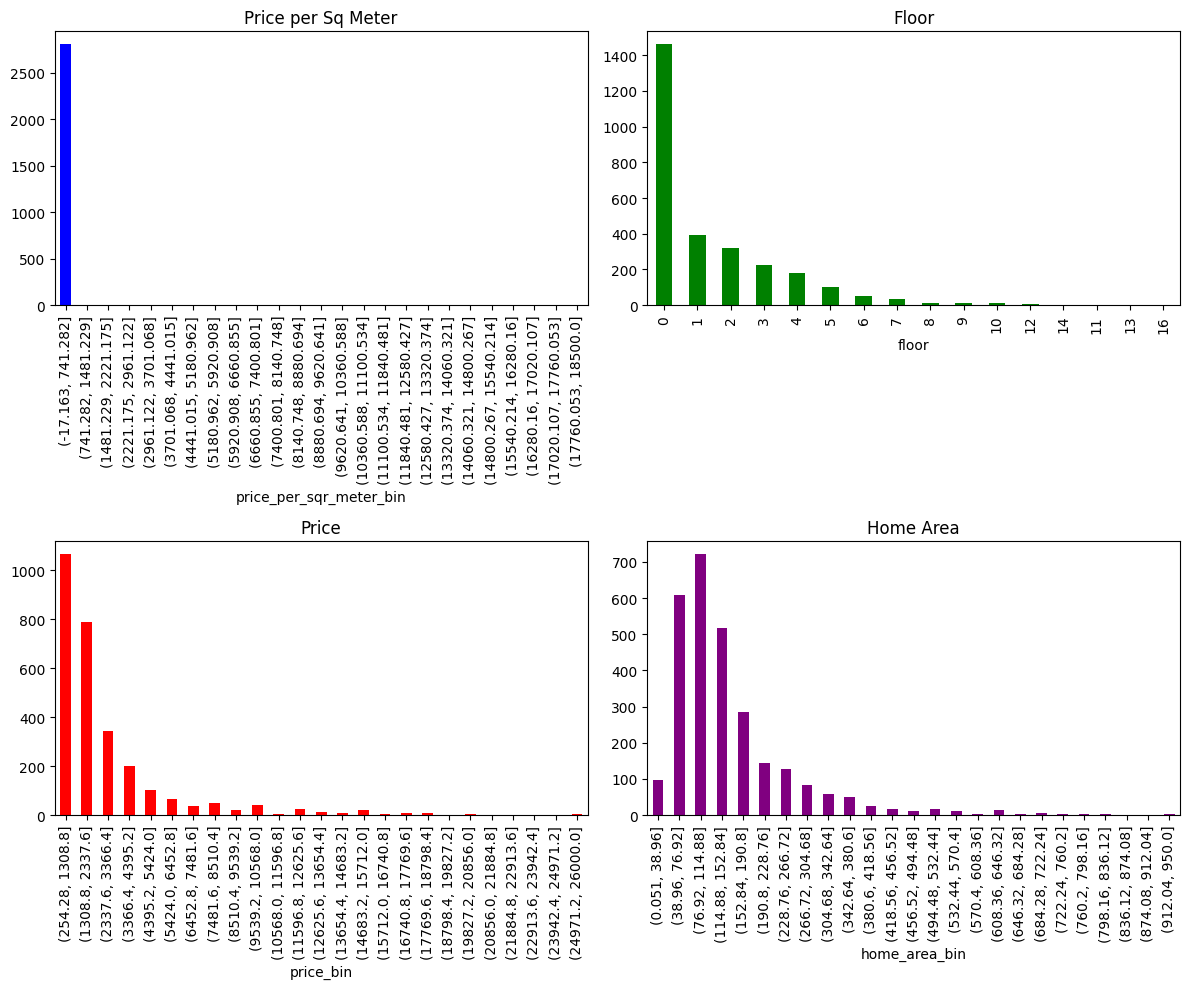

In [319]:
import matplotlib.pyplot as plt

def plot_numeric(data, nbins = 15):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figure size as needed

    # Plot for price_per_sqr_meter
    data['price_per_sqr_meter_bin'] = pd.cut(data['price_per_sqr_meter'], bins=nbins)  # Binning into 5 categories
    data['price_per_sqr_meter_bin'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='blue', title='Price per Sq Meter')

    # Plot for floor
    data['floor'].value_counts().plot(kind='bar', ax=axes[0, 1], color='green', title='Floor')

    # Plot for price
    data['price_bin'] = pd.cut(data['price'], bins=nbins)  # Binning into 5 categories
    data['price_bin'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='red', title='Price')

    # Plot for home_area
    data['home_area_bin'] = pd.cut(data['home_area'], bins=nbins)  # Binning into 5 categories
    data['home_area_bin'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='purple', title='Home Area')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_numeric(data, nbins = 25)

In [320]:
# remove houses bigger than T6, does not make sense for the analysis
# data = data[data["home_size"].isin(["T0", "T1", "T2", "T3", "T4", "T5", "T6"])]
data.head(5)

,title,link,description,garage,price,home_type,city,home_size,home_area,floor,elevator,price_per_sqr_meter,date,neighborhood,price_per_sqr_meter_bin,price_bin,home_area_bin
0,"Apartamento T3, Terreiro Esperança, Centro de...",https://www.idealista.pt/imovel/33396790/,A EMBAIXADA DA CASA Apresenta este apartamento...,False,1200,Apartamento,Almada,T3,31,0,False,38.709677,13-05-2024,Laranjeiro e Feijó,"(-17.163, 741.282]","(254.28, 1308.8]","(0.051, 38.96]"
1,"Apartamento T3 na rua Martins Afonso de Sousa,...",https://www.idealista.pt/imovel/33281382/,Opção de mobília e equipamento de cozinha para...,False,1250,Apartamento,Almada,T3,90,1,False,13.888889,13-05-2024,Almada - Cova da Piedade - Pragal - Cacilhas,"(-17.163, 741.282]","(254.28, 1308.8]","(76.92, 114.88]"
2,Apartamento T1 em Almada,https://www.idealista.pt/imovel/30954625/,Disponível a partir de 01 de Junho de 2024.\nE...,False,925,Apartamento,Almada,T1,65,8,True,14.230769,13-05-2024,Apartamento T1 em Almada,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"
3,"Apartamento T2 em Santo António, Costa de Capa...",https://www.idealista.pt/imovel/32744859/,"T2 de 70m2, luminoso, mobilado e equipado na C...",False,1150,Apartamento,Almada,T2,71,1,False,16.197183,13-05-2024,Costa de Caparica,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"
4,"Apartamento T2 na avenida Rainha Dona Leonor, ...",https://www.idealista.pt/imovel/33396657/,"Apartamento de 2 assoalhadas, totalmente remod...",False,1200,Apartamento,Almada,T2,72,0,False,16.666667,13-05-2024,Almada,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"


In [321]:
original_len = len(data)

def filter_city_group(group):
    # Calculate quantiles within each group
    c1 = group['price_per_sqr_meter'].quantile(0.99)
    c2 = group['price'].quantile(0.99)
    c3 = group['home_area'].quantile(0.99)
    
    # Filter based on the upper quantiles
    filtered_group = group[(group['price_per_sqr_meter'] <= c1) & 
                           (group['price'] <= c2) & 
                           (group['home_area'] <= c3)]
    
    # Calculate the lower quantile for price_per_sqr_meter
    c4 = filtered_group['price_per_sqr_meter'].quantile(0.025)
    
    # Further filter the group
    final_filtered_group = filtered_group[filtered_group['price_per_sqr_meter'] > c4]
    
    return final_filtered_group

data = data.groupby(['city', 'home_size']).apply(filter_city_group).reset_index(drop=True)
data.head(5)

,title,link,description,garage,price,home_type,city,home_size,home_area,floor,elevator,price_per_sqr_meter,date,neighborhood,price_per_sqr_meter_bin,price_bin,home_area_bin
0,"Apartamento T0 em São João da Caparica, Costa ...",https://www.idealista.pt/imovel/33182313/,"Apartamento T0, com vista de Mar.\nNão perca a...",False,1250,Apartamento,Almada,T0,60,10,True,20.833333,13-05-2024,Costa de Caparica,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"
1,"Apartamento T0 em São João da Caparica, Costa ...",https://www.idealista.pt/imovel/33225472/,Não perca a oportunidade de viver num apartame...,False,1200,Apartamento,Almada,T0,57,6,True,21.052632,13-05-2024,Costa de Caparica,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"
2,"Apartamento T0 na avenida da Liberdade, 5, Cap...",https://www.idealista.pt/imovel/33132721/,"Excelente apartamento t1 na Trafaria, a 2 minu...",False,1200,Apartamento,Almada,T0,50,1,False,24.000000,13-05-2024,Almada,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"
3,"Apartamento T0 na rua Eleutério Teixeira, 8, C...",https://www.idealista.pt/imovel/33394837/,"Estúdio com muita luz, casa de banho com duche...",False,1000,Apartamento,Almada,T0,50,0,False,20.000000,13-05-2024,Almada,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"
4,Apartamento T1 em Almada,https://www.idealista.pt/imovel/30954625/,Disponível a partir de 01 de Junho de 2024.\nE...,False,925,Apartamento,Almada,T1,65,8,True,14.230769,13-05-2024,Apartamento T1 em Almada,"(-17.163, 741.282]","(254.28, 1308.8]","(38.96, 76.92]"


In [322]:
print(f'{original_len- len(data)} rows were removed. \n Original df: {original_len}\n Filtered df: {len(data)}')

356 rows were removed. 
 Original df: 2810
 Filtered df: 2454


In [323]:
# we can also define some business rules based on fixed values
# as long as the values have some ground of truth
"""original_len = len(data)

c1 = data['price_per_sqr_meter'].quantile(0.95) # 50 € per sqr meter is also crazy
c2 = data['price'].quantile(0.95)
c3 = data['home_area'].quantile(0.95) # makes no sense to consider a house with less than 20m2
data = data[(data['price_per_sqr_meter'] <= c1) & 
            (data['price'] <= c2) & 
            (data['home_area'] <= c3)]

c4 = data['price_per_sqr_meter'].quantile(0.05)
data = data[data['price_per_sqr_meter'] > c4]
display(data.describe())"""

"original_len = len(data)\n\nc1 = data['price_per_sqr_meter'].quantile(0.95) # 50 € per sqr meter is also crazy\nc2 = data['price'].quantile(0.95)\nc3 = data['home_area'].quantile(0.95) # makes no sense to consider a house with less than 20m2\ndata = data[(data['price_per_sqr_meter'] <= c1) & \n            (data['price'] <= c2) & \n            (data['home_area'] <= c3)]\n\nc4 = data['price_per_sqr_meter'].quantile(0.05)\ndata = data[data['price_per_sqr_meter'] > c4]\ndisplay(data.describe())"

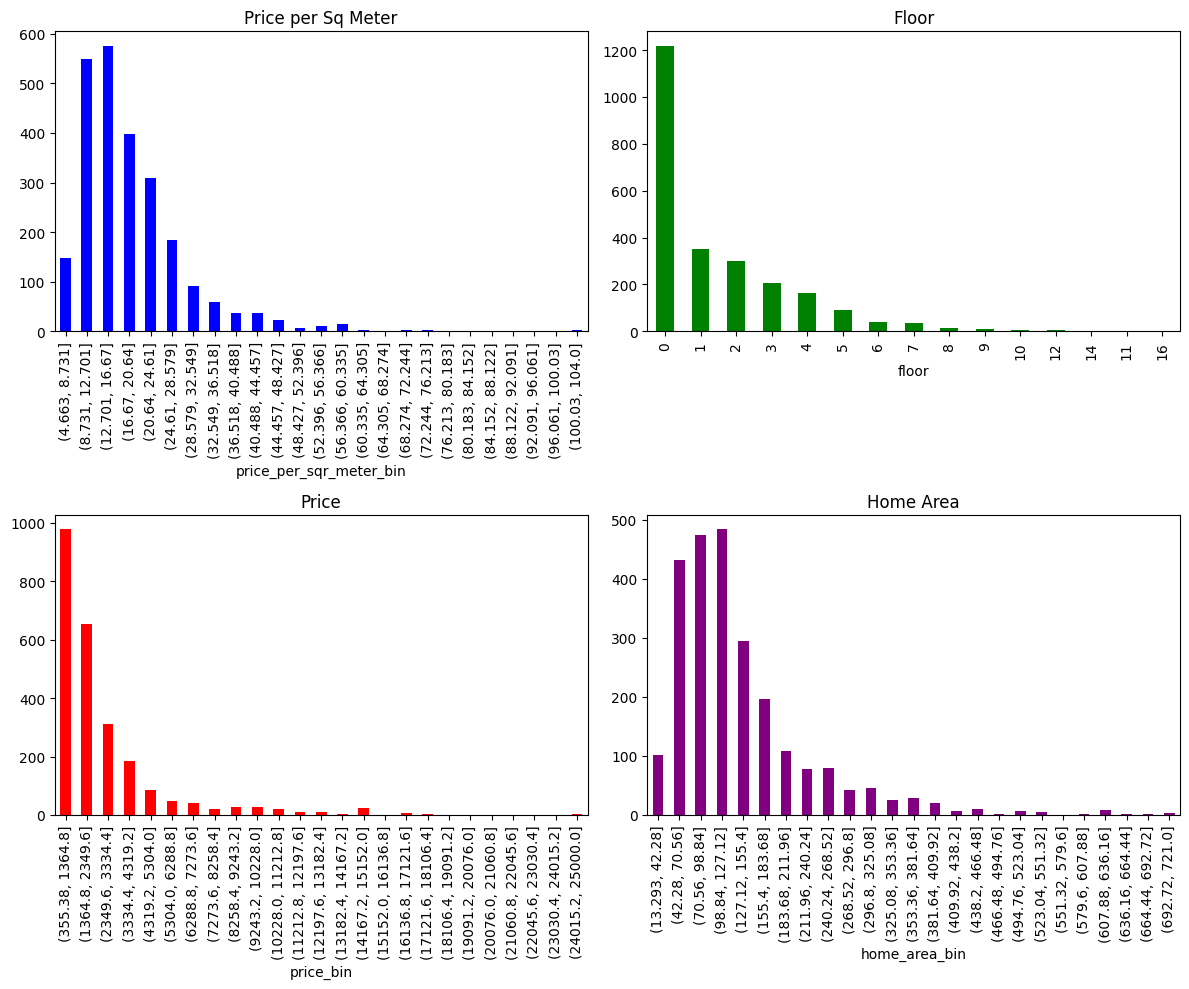

In [324]:
plot_numeric(data, nbins = 25)

In [325]:
def preprocess_text(text):
    """
    Preprocesses the given text string by:
    - Stripping whitespace from start and end.
    - Converting all characters to lowercase.
    - Replacing accented characters with their closest ASCII counterparts.
    - Optionally: remove punctuation, digits, etc.

    Args:
        text (str): The text to preprocess.

    Returns:
        str: The preprocessed text.
    """

    # Normalize to a consistent form
    text = unicodedata.normalize('NFKD', text)

    # Strip whitespace
    text = text.strip()

    # Convert to lowercase
    text = text.lower()

    # Replace accented characters with ASCII equivalents
    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove specific unwanted characters such as newlines and slashes
    text = re.sub(r'[\n/]', ' ', text)  # Replacing them with a space

    # Optionally: remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Optionally: remove digits
    # text = re.sub(r'\d+', '', text)

    return text

In [326]:
string_columns = ["title", "home_type", "neighborhood", "home_size", "city"] # i dont want to apply it to description

In [327]:
for col in string_columns:
    data[col] = data[col].apply(preprocess_text)
    

display(data.head(5))

,title,link,description,garage,price,home_type,city,home_size,home_area,floor,elevator,price_per_sqr_meter,date,neighborhood,price_per_sqr_meter_bin,price_bin,home_area_bin
0,apartamento t0 em sao joao da caparica costa d...,https://www.idealista.pt/imovel/33182313/,"Apartamento T0, com vista de Mar.\nNão perca a...",False,1250,apartamento,almada,t0,60,10,True,20.833333,13-05-2024,costa de caparica,"(20.64, 24.61]","(355.38, 1364.8]","(42.28, 70.56]"
1,apartamento t0 em sao joao da caparica costa d...,https://www.idealista.pt/imovel/33225472/,Não perca a oportunidade de viver num apartame...,False,1200,apartamento,almada,t0,57,6,True,21.052632,13-05-2024,costa de caparica,"(20.64, 24.61]","(355.38, 1364.8]","(42.28, 70.56]"
2,apartamento t0 na avenida da liberdade 5 capar...,https://www.idealista.pt/imovel/33132721/,"Excelente apartamento t1 na Trafaria, a 2 minu...",False,1200,apartamento,almada,t0,50,1,False,24.000000,13-05-2024,almada,"(20.64, 24.61]","(355.38, 1364.8]","(42.28, 70.56]"
3,apartamento t0 na rua eleuterio teixeira 8 cap...,https://www.idealista.pt/imovel/33394837/,"Estúdio com muita luz, casa de banho com duche...",False,1000,apartamento,almada,t0,50,0,False,20.000000,13-05-2024,almada,"(16.67, 20.64]","(355.38, 1364.8]","(42.28, 70.56]"
4,apartamento t1 em almada,https://www.idealista.pt/imovel/30954625/,Disponível a partir de 01 de Junho de 2024.\nE...,False,925,apartamento,almada,t1,65,8,True,14.230769,13-05-2024,apartamento t1 em almada,"(12.701, 16.67]","(355.38, 1364.8]","(42.28, 70.56]"


In [328]:
def clean_neighborhood_name(name, remove_words):
    """
    Clean a single neighborhood name by removing specified words.

    Args:
    name (str): The neighborhood name to clean.
    remove_words (set): A set of words to remove from the name.

    Returns:
    str: The cleaned neighborhood name.
    """
    if len(name.split()) > 1:
        pattern = r'\b(' + '|'.join(remove_words) + r')\b'
        cleaned_name = re.sub(pattern, '', name, flags=re.IGNORECASE).strip()
        cleaned_name = re.sub(r'\s+', ' ', cleaned_name)
    else:
        cleaned_name = name
        
    return cleaned_name

In [329]:
remove_words = set(list(data["home_type"].unique()) + list(data["home_size"].unique()))

data["neighborhood"] = data["neighborhood"].apply(lambda x: clean_neighborhood_name(x, remove_words))
data["neighborhood"].unique()

array(['costa de caparica', 'almada', 'em almada',
       'charneca da caparica e sobreda',
       'almada cova da piedade pragal cacilhas', 'laranjeiro e feijo',
       'gloria e vera cruz', 'aveiro', 'sao domingos de rana',
       'cascais e estoril', 'carcavelos e parede', 'alcabideche',
       'cidade de coimbra', 'coimbra', 'santo antonio dos olivais',
       'sao cosme valbom jovim', 'rio tinto', 'gondomar', 'guimaraes',
       'leiria', 'loures', 'camarate unhos apelacao', 'maia',
       'cidade da maia', 'sao mamede de infesta e senhora da hora',
       'matosinhos e leca da palmeira', 'matosinhos',
       'custoias leca do balio guifoes', 'setubal', 'sao sebastiao',
       'azeitao', 'massama e monte abraao', 'cacem e sao marcos',
       'sintra', 'rio de mouro', 'queluz e belas', 'colares',
       'agualva e mira sintra', 'algueirao mem martins',
       'viana do castelo e meadela', 'viana do castelo',
       'santa marinha e sao pedro da afurada', 'canidelo',
       'mafamud

In [330]:
def extract_street_names(text):
    # Process the text
    # doc = nlp(text)

    # Filter out stop words
    # filtered_sentence = ' '.join([token.text for token in doc if not token.is_stop])   
    
    """Extract potential street names from a text string using spaCy's NER."""
    doc = nlp(text)
    # Customize entity labels based on observations and model performance
    street_entities = ['LOC', 'PROPN']
    street_names = [ent.text for ent in doc.ents if ent.label_ in street_entities]

    return ' '.join(street_names)

data['street_names'] = data['title'].apply(extract_street_names)
data["street_names"] = data["street_names"].apply(lambda x: clean_neighborhood_name(x, remove_words))

# replace "" values from the columns to the value of neighborhood
data['street_names'] = np.where(data['street_names'] == '', data['neighborhood'], data['street_names'])
agg_list = data.groupby('neighborhood')['street_names'].agg(list)

display(data["street_names"].nunique())
display(agg_list)

530

neighborhood
agualva e mira sintra                      [ponte nova 9 mira sintra, agualva mira sintra...
alcabideche                                [alcabideche, alcabideche, alcabideche, alcabi...
algueirao mem martins                      [algueirao mem martins, algueirao mem martins,...
almada                                     [avenida da liberdade 5 caparica, almada, alma...
almada cova da piedade pragal cacilhas     [cova da piedade pragal cacilhas, cova da pied...
arcozelo                                   [arcozelo, arcozelo, arcozelo, arcozelo, duple...
aveiro                                     [aveiro, aveiro, aveiro, aveiro, aveiro, aveir...
azeitao                                    [azeitao, de aldeia, azeitao, azeitao, rua de ...
cacem e sao marcos                         [cacem e sao marcos, sao paulo 7, avenida do b...
camarate unhos apelacao                    [rua manuel joao, camarate unhos apelacao, rua...
canelas                                                  

In [331]:
from collections import Counter
from collections import OrderedDict

def count_elements(series):
    """ Returns a dictionary with the counts of each element in the list for each group. """

    return series.apply(Counter)

def sort_dict_by_values(d):
    """ Sort a dictionary by its values in descending order """

    return OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True))

street_name_counts = count_elements(agg_list)
street_name_counts = street_name_counts.apply(sort_dict_by_values)
display(street_name_counts)

neighborhood
agualva e mira sintra                      {'mira sintra': 6, 'ponte nova 9 mira sintra':...
alcabideche                                {'alcabideche': 51, 'amoreira alcabideche': 5,...
algueirao mem martins                      {'algueirao mem martins': 11, 't2': 2, 'casal ...
almada                                     {'almada': 22, 'caparica': 2, 'avenida rainha ...
almada cova da piedade pragal cacilhas     {'cova da piedade pragal cacilhas': 11, 'almad...
arcozelo                                   {'arcozelo': 6, 'duplex': 1, 'santa maria adel...
aveiro                                     {'aveiro': 6, 'sao bernardo': 1, 'rua vasco da...
azeitao                                    {'azeitao': 12, 'de aldeia': 1, 'rua de lisboa...
cacem e sao marcos                         {'cacem e sao marcos': 8, 'avenida do brasil':...
camarate unhos apelacao                    {'camarate camarate unhos': 2, 'rua manuel joa...
canelas                                                  

In [332]:
grouped_data = data.groupby(["city", "neighborhood"])["street_names"].agg(list).reset_index()
# grouped_data.dropna(axis = 0).to_excel("cities.xlsx")
data.to_csv("preprocessed_data.csv")